In [ ]:
!git clone https://github.com/hideakihata/BugReportClassificationDataset.git

Cloning into 'BugReportClassificationDataset'...
remote: Enumerating objects: 11892, done.
remote: Total 11892 (delta 0), reused 0 (delta 0), pack-reused 11892
Receiving objects: 100% (11892/11892), 197.41 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (4554/4554), done.


In [ ]:
!cp -r BugReportClassificationDataset/BugReportCSV ./BugReportCSV
!cp -r BugReportClassificationDataset/CorrectiveDataset ./CorrectiveDataset
!rm -rf BugReportClassificationDataset

In [20]:
%pip install scikit-learn-intelex dpcpp-cpp-rt xgboost lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import codecs
import json
import os
import csv
import time
import warnings
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import daal4py as d4p
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import pickle

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Flatten, Input, Activation, PReLU, LeakyReLU, ThresholdedReLU

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearnex import patch_sklearn, unpatch_sklearn


2023-03-23 10:50:43.059785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Preprocessing

In [22]:
project_ids = ["HTTPCLIENT", "JACKRABBIT", "LUCENE"]

def load_data():
    httpclient_ids_df = pd.read_csv('./CorrectiveDataset/httpclient_classification_vs_type.csv')
    jackrabbit_ids_df = pd.read_csv('./CorrectiveDataset/jackrabbit_classification_vs_type.csv')
    lucene_ids_df = pd.read_csv('./CorrectiveDataset/lucene_classification_vs_type.csv')

    issues_df = pd.concat([httpclient_ids_df, jackrabbit_ids_df, lucene_ids_df], ignore_index=True)
    issues_df["title"] = np.nan; issues_df["desc"] = np.nan;

    for id in project_ids:
        basepath = f'./BugReportCSV/{id}/WithComment/'
        for issue in os.listdir(basepath):
            issue_id = issue.split('.txt')[0]
            issue_content = open(basepath+issue, 'r', encoding='latin-1').read().split('\n')
            issues_df.loc[issues_df['ID'] == issue_id, ['title']] = issue_content[0]
            issues_df.loc[issues_df['ID'] == issue_id, ['desc']] = issue_content[1]

    issues_df = issues_df.dropna(subset=['title', 'desc'])

    def categorize(row):
        return 'BUG' if (row['CLASSIFIED'] == 'BUG' and row['TYPE'] == 'BUG') else 'NBUG'

    issues_df['label'] = issues_df.apply(lambda row: categorize(row), axis=1)
    return json.loads(issues_df.to_json(orient='records'))
    # issues_df['label'].value_counts()

In [23]:
boost_summary = 3

def get_corpus_labels(raw_data):
    # Corpus building.
    corpus = []
    labels = []
    n_bug = 0
    for n_file in raw_data:
        txt = ""
        for i in range(boost_summary):
            txt += n_file["title"] + " "

        corpus.append(txt + " " + n_file["desc"])
        labels.append(n_file["label"])
        if n_file["label"] == "BUG":
            n_bug += 1
    print(f"{n_bug} BUG / {len(labels)} \n")
    return corpus, labels

In [ ]:
def feature_computing(corpus, labels, vectorizer, feature_selection = True, k_best=50000):
    # TF-IDF
    print("Feature computing:")
    X = vectorizer.fit_transform(corpus)
    print(f"\t{X.shape[1]} features.")

    if feature_selection:
        print("Extracting %d best features by a chi-squared test" % k_best)
        ch2 = SelectKBest(chi2, k=k_best)
        X = ch2.fit_transform(X, labels)
        return X, vectorizer, ch2

    return X, vectorizer

In [ ]:
def labels_binarizing(labels):
    lb = LabelBinarizer()
    # Binarize labels with BUG = 0 and NBUG = 1
    labels = np.array([number[0] for number in lb.fit_transform(labels)])
    # Inverse 0 and 1 to have good labels, i.e BUG = 1 and NBUG = 0
    return np.logical_not(labels).astype(int)

In [14]:
raw_data = load_data()
corpus, labels = get_corpus_labels(raw_data)
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 3), stop_words=["english"], sublinear_tf=True)
X, vectorizer, chi = feature_computing(corpus, labels, vectorizer, feature_selection=True)
# Uncomment to save selector and vectorizer
# pickle.dump(chi, open("selector.pkl","wb"))
# pickle.dump(vectorizer, open("vectorizer.pkl","wb"))
binarized_labels = labels_binarizing(labels)

1887 BUG / 5590 

Feature computing.
	436281 features.
Extracting 50000 best features by a chi-squared test


ValueError: too many values to unpack (expected 3)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, binarized_labels, test_size=0.3)

### Multilayer Perceptron

In [34]:
def score_multilayer_perceptron_optimized(X_train, X_test, y_train, y_test):
    patch_sklearn()
    
    mlp = MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=20, random_state=0)
    print("=====> Scoring MLP <=====")
    t_start = time.time()
    mlp.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = mlp.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4
    
    # Uncomment to save model
#     with open('mlp.pkl', 'wb') as f:
#         pickle.dump(mlp, f)
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

In [35]:
def score_multilayer_perceptron_unoptimized(X_train, X_test, y_train, y_test):
    unpatch_sklearn()
    
    mlp = MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=20, random_state=0)
    print("=====> Scoring MLP <=====")
    t_start = time.time()
    mlp.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = mlp.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

=====> Scoring MLP <=====
Time: 37.743436098098755
              precision    recall  f1-score   support

           0     0.8871    0.9741    0.9286      1121
           1     0.9350    0.7500    0.8323       556

    accuracy                         0.8998      1677
   macro avg     0.9110    0.8621    0.8805      1677
weighted avg     0.9030    0.8998    0.8967      1677



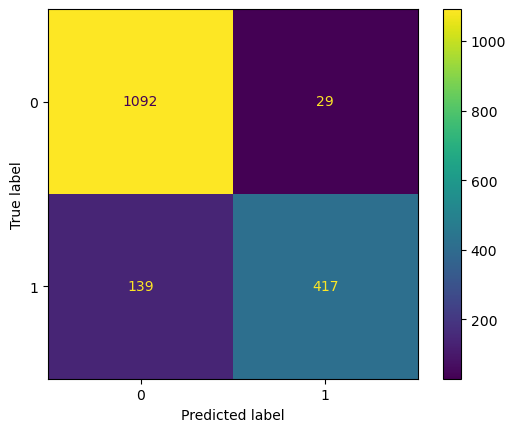

In [36]:
score_multilayer_perceptron_unoptimized(X_train, X_test, y_train, y_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


=====> Scoring MLP <=====
Time: 36.92686891555786
              precision    recall  f1-score   support

           0     0.8871    0.9741    0.9286      1121
           1     0.9350    0.7500    0.8323       556

    accuracy                         0.8998      1677
   macro avg     0.9110    0.8621    0.8805      1677
weighted avg     0.9030    0.8998    0.8967      1677



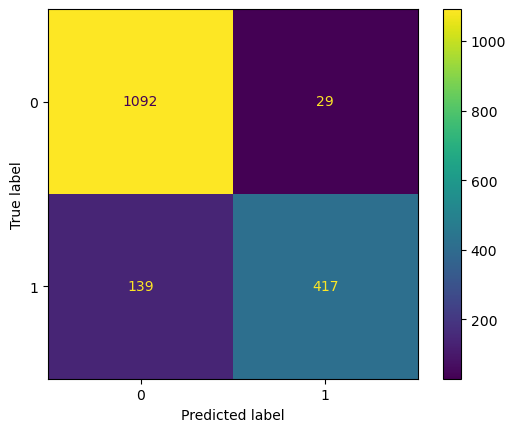

In [39]:
score_multilayer_perceptron_optimized(X_train, X_test, y_train, y_test)

### SVM

In [15]:
def score_svm_unoptimized(X_train, X_test, y_train, y_test):
    unpatch_sklearn()
    svm = SVC(C=100, gamma='scale')
    
    print("=====> Scoring SVM <=====")
    t_start = time.time()
    svm.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = svm.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

In [16]:
def score_svm_optimized(X_train, X_test, y_train, y_test):
    patch_sklearn()
    svm = SVC(C=100, gamma='scale')
    
    print("=====> Scoring SVM <=====")
    t_start = time.time()
    svm.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = svm.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

=====> Scoring SVM <=====
Time: 19.43800950050354
              precision    recall  f1-score   support

           0     0.9166    0.9256    0.9211      1116
           1     0.8491    0.8324    0.8407       561

    accuracy                         0.8945      1677
   macro avg     0.8828    0.8790    0.8809      1677
weighted avg     0.8940    0.8945    0.8942      1677



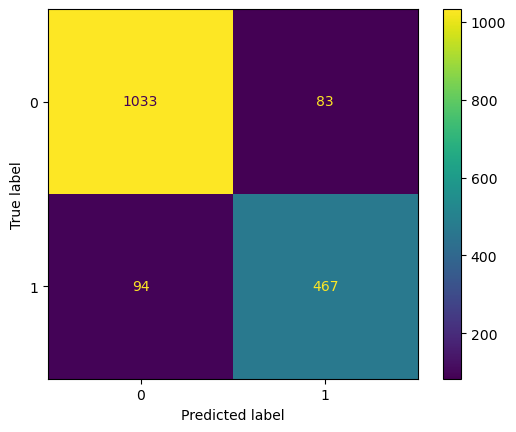

In [17]:
score_svm_unoptimized(X_train, X_test, y_train, y_test)

=====> Scoring SVM <=====


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Time: 19.390804767608643
              precision    recall  f1-score   support

           0     0.9166    0.9256    0.9211      1116
           1     0.8491    0.8324    0.8407       561

    accuracy                         0.8945      1677
   macro avg     0.8828    0.8790    0.8809      1677
weighted avg     0.8940    0.8945    0.8942      1677



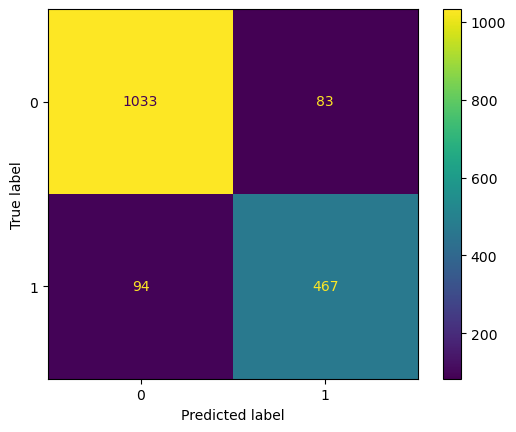

In [18]:
score_svm_optimized(X_train, X_test, y_train, y_test)

### Stochastic Gradient Descent

In [22]:
def score_sgd_optimized(X_train, X_test, y_train, y_test):
    patch_sklearn()
    sgd = SGDClassifier(random_state=0, loss='modified_huber', max_iter=10000)

    print("=====> Scoring SGD <=====")
    t_start = time.time()
    sgd.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = sgd.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

In [23]:
def score_sgd_unoptimized(X_train, X_test, y_train, y_test):
    unpatch_sklearn()
    sgd = SGDClassifier(random_state=0, loss='modified_huber', max_iter=10000)

    print("=====> Scoring SGD <=====")
    t_start = time.time()
    sgd.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = sgd.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

=====> Scoring SGD <=====
Time: 0.04142189025878906
              precision    recall  f1-score   support

           0     0.8826    0.9498    0.9150      1116
           1     0.8824    0.7487    0.8100       561

    accuracy                         0.8825      1677
   macro avg     0.8825    0.8492    0.8625      1677
weighted avg     0.8825    0.8825    0.8799      1677



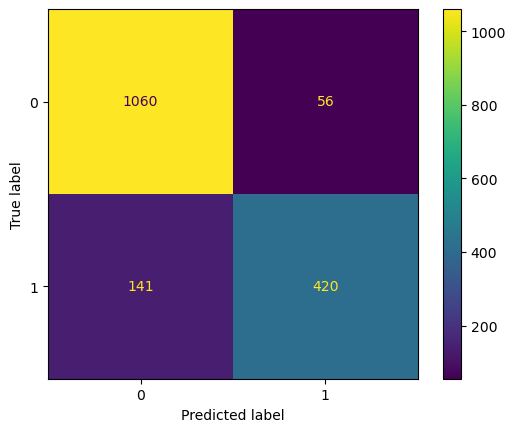

In [39]:
score_sgd_unoptimized(X_train, X_test, y_train, y_test)

=====> Scoring SGD <=====
Time: 0.02962636947631836
              precision    recall  f1-score   support

           0     0.8826    0.9498    0.9150      1116
           1     0.8824    0.7487    0.8100       561

    accuracy                         0.8825      1677
   macro avg     0.8825    0.8492    0.8625      1677
weighted avg     0.8825    0.8825    0.8799      1677



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


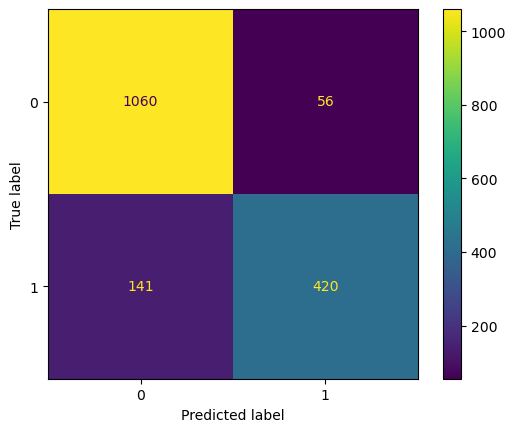

In [43]:
score_sgd_optimized(X_train, X_test, y_train, y_test)

### LightGBM

In [49]:
def score_lightgbm_optimized(X_train, X_test, y_train, y_test):
    patch_sklearn()
    clf = lgb.LGBMClassifier()
    
    print("=====> Scoring LightGBM <=====")
    t_start = time.time()
    clf.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = clf.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

In [50]:
def score_lightgbm_unoptimized(X_train, X_test, y_train, y_test):
    unpatch_sklearn()
    clf = lgb.LGBMClassifier()
    
    print("=====> Scoring LightGBM <=====")
    t_start = time.time()
    clf.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = clf.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

=====> Scoring LightGBM <=====
Time: 3.750791549682617
              precision    recall  f1-score   support

           0     0.8661    0.8987    0.8821      1116
           1     0.7823    0.7237    0.7519       561

    accuracy                         0.8402      1677
   macro avg     0.8242    0.8112    0.8170      1677
weighted avg     0.8381    0.8402    0.8386      1677



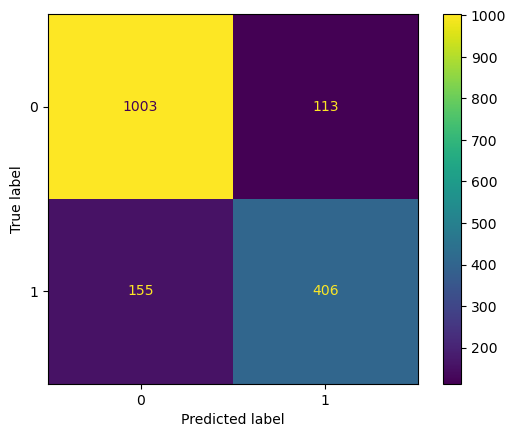

In [51]:
score_lightgbm_unoptimized(X_train, X_test, y_train, y_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


=====> Scoring LightGBM <=====
Time: 3.486720323562622
              precision    recall  f1-score   support

           0     0.8661    0.8987    0.8821      1116
           1     0.7823    0.7237    0.7519       561

    accuracy                         0.8402      1677
   macro avg     0.8242    0.8112    0.8170      1677
weighted avg     0.8381    0.8402    0.8386      1677



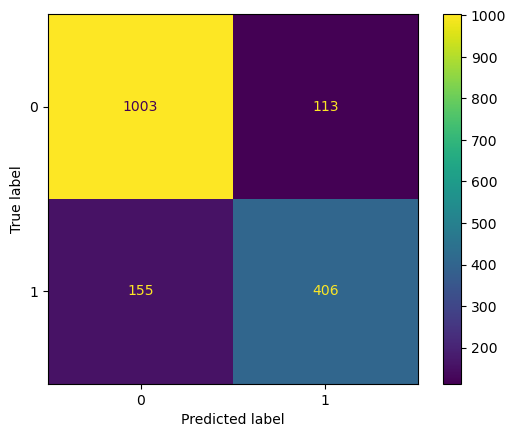

In [52]:
score_lightgbm_optimized(X_train, X_test, y_train, y_test)

### Logistic Regression

In [8]:
def score_logisreg_optimized(X_train, X_test, y_train, y_test):
    patch_sklearn()
    lreg = LogisticRegression(random_state=0, max_iter=10000)
    
    print("=====> Scoring Logistic Regression <=====")
    t_start = time.time()
    lreg.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = lreg.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

In [9]:
def score_logisreg_unoptimized(X_train, X_test, y_train, y_test):
    unpatch_sklearn()
    lreg = LogisticRegression(random_state=0, max_iter=10000)
    
    print("=====> Scoring Logistic Regression <=====")
    t_start = time.time()
    lreg.fit(X_train, y_train)
    t_end = time.time()
    
    fit_time = t_end - t_start
    
    t_start = time.time()
    preds = lreg.predict(X_test)
    t_end = time.time()
    
    pred_time = t_end - t_start
    
    print ("Time:", pred_time + fit_time)
    print (classification_report(y_test, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()

=====> Scoring Logistic Regression <=====
Time: 0.5433769226074219
              precision    recall  f1-score   support

           0     0.7567    0.9649    0.8482      1083
           1     0.8716    0.4343    0.5798       594

    accuracy                         0.7770      1677
   macro avg     0.8142    0.6996    0.7140      1677
weighted avg     0.7974    0.7770    0.7531      1677



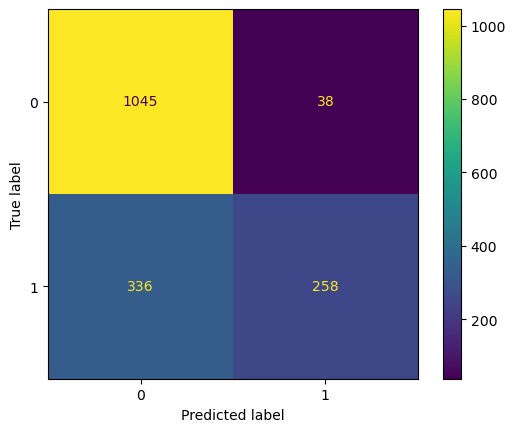

In [10]:
score_logisreg_unoptimized(X_train, X_test, y_train, y_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


=====> Scoring Logistic Regression <=====
Time: 0.3911004066467285
              precision    recall  f1-score   support

           0     0.7567    0.9649    0.8482      1083
           1     0.8716    0.4343    0.5798       594

    accuracy                         0.7770      1677
   macro avg     0.8142    0.6996    0.7140      1677
weighted avg     0.7974    0.7770    0.7531      1677



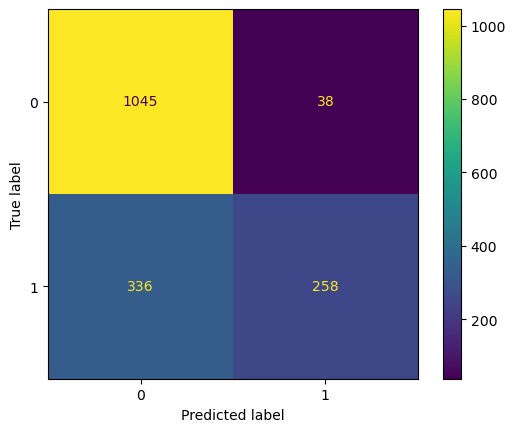

In [14]:
score_logisreg_optimized(X_train, X_test, y_train, y_test)

### XGBoost

In [15]:
def score_xgboost(X_train, X_test, y_train, y_test):
    patch_sklearn()
    print("=====> Scoring XGBoost <=====")

    train_algo = d4p.gbt_classification_training(
        nClasses=2,
        featuresPerNode=50000
    )
    train_res = train_algo.compute(X_train, y_train)
    predict_algo = d4p.gbt_classification_prediction(
        nClasses=2,
        resultsToEvaluate="computeClassLabels|computeClassProbabilities"
    )
    predict_result = predict_algo.compute(X_test, train_res.model)
    print (classification_report(y_test, predict_result.prediction))    
    ConfusionMatrixDisplay.from_predictions(y_test, predict_result.prediction)
    plt.show()


(3913, 50000) (1677, 50000) (3913, 1) (1677, 1)
=====> Scoring XGBoost <=====


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1083
           1       0.78      0.65      0.71       594

    accuracy                           0.81      1677
   macro avg       0.80      0.78      0.79      1677
weighted avg       0.81      0.81      0.81      1677



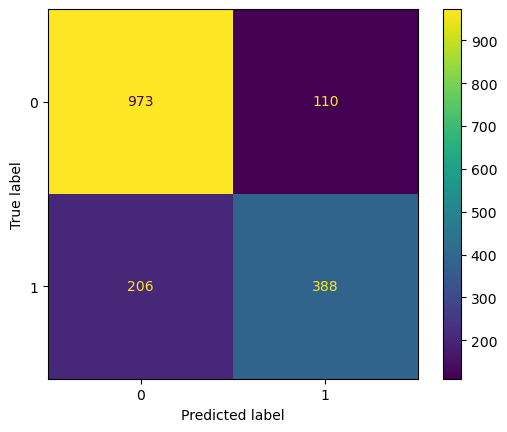

In [16]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
score_xgboost(X_train, X_test, y_train, y_test)

### Model Test

In [ ]:
def build_tfidf_model(features, labels, optimizer, activations, drop_rate, lr, layer1_size, layer2_size=None, layer3_size=None, layer4_size=None):
    
    model = models.Sequential()
    model.add(Input(shape=[features.shape[1]], name="TFIDF_Features"))
    model.add(Dense(layer1_size, input_shape=[features.shape[1]]))
    
    if activations[0] == "leaky":
        model.add(LeakyReLU())
    elif activations[0] == "prelu":
        model.add(PReLU())
    else:
        model.add(Activation(activations[0]))     
        
    if layer2_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer2_size))
        
        if activations[1] == "leaky":
            model.add(LeakyReLU())
        elif activations[0] == "prelu":
            model.add(PReLU())
        else:
            model.add(Activation(activations[1]))      
            
            
    if layer3_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer3_size))
        
        if activations[2] == "leaky":
            model.add(LeakyReLU())
        elif activations[0] == "prelu":
            model.add(PReLU())
        else:
            model.add(Activation(activations[2]))   
            
            
    if layer4_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer4_size))
        
        if activations[3] == "leaky":
            model.add(LeakyReLU())
        elif activations[0] == "prelu":
            model.add(PReLU())
        else:
            model.add(Activation(activations[3]))
            
            
    model.add(Dropout(drop_rate, trainable=True))
    model.add(Dense(1, activation='sigmoid'))
    
    # Parameters
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax() # Use default learning rate for adamax
    elif optimizer == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(lr)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(lr )
    else:
        print("ERROR: No valid optimizer passed")
        return None
    
    
    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    

    return model

In [ ]:
# Construct the model itself:
assignment_model = build_tfidf_model(features = X_train, 
                                     labels = y_train, 
                                     optimizer = 'adam',
                                     activations = ['prelu', 'prelu', 'prelu', 'prelu'],
                                     drop_rate=0.3,
                                     lr=0.0001,
                                     layer1_size = 2048,
                                     layer2_size= 512, 
                                     layer3_size= 256,
                                     layer4_size= 128)
# assignment_model.summary()
history_tfidf = assignment_model.fit(
  X_train.toarray(), y_train,
  batch_size=16,
  epochs=10, validation_split=0.3, verbose=1,
)

Epoch 1/10
172/172 [==============================] - 45s 257ms/step - loss: 0.5829 - accuracy: 0.6846 - val_loss: 0.4336 - val_accuracy: 0.8186
Epoch 2/10
172/172 [==============================] - 43s 251ms/step - loss: 0.1975 - accuracy: 0.9354 - val_loss: 0.2753 - val_accuracy: 0.8969
Epoch 3/10
172/172 [==============================] - 45s 260ms/step - loss: 0.0180 - accuracy: 0.9971 - val_loss: 0.3520 - val_accuracy: 0.8773
Epoch 4/10
172/172 [==============================] - 43s 248ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3967 - val_accuracy: 0.8756
Epoch 5/10
172/172 [==============================] - 44s 254ms/step - loss: 9.5669e-04 - accuracy: 1.0000 - val_loss: 0.4183 - val_accuracy: 0.8816
Epoch 6/10
172/172 [==============================] - 45s 260ms/step - loss: 5.1819e-04 - accuracy: 1.0000 - val_loss: 0.4385 - val_accuracy: 0.8816
Epoch 7/10
172/172 [==============================] - 45s 262ms/step - loss: 3.1954e-04 - accuracy: 1.0000 - val_loss: 0.4